In [1]:
import os 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import scipy
from scipy.stats import shapiro
from scipy.stats import ttest_rel,wilcoxon

### 1 Data extraction
#### 1.0  import raw event data (.csv files)

In [2]:
# Directories (adjust if required):
DATA_DIRECTORY    = '../Data'  #Root folder containing the folders for each participant
OUTPUT_DIRECTORY  = './Out'

# Participants to include in analysis
PARTICIPANTS      = ['HC04','HC05','HC06','HC07','HC08','HC09','HC11',
                     'HC12','HC13','HC14','HC15','HC16','HC17','HC18',
                     'HC19', 'HC20','HC21', 'HC22','HC23','HC24']


# Dataframe to store the raw event data of all participants
raw_data = pd.DataFrame()

for i,participant in enumerate(PARTICIPANTS):
    part_directory    = os.path.join(DATA_DIRECTORY,participant)
    events_directory  = os.path.join(part_directory,'Events')
    
    # Read timestamps
    filename   = os.path.join(events_directory,'{}_timestamps.csv'.format(participant)) 
    timestamps = pd.read_csv(filename,sep=',',converters={"events": lambda x: [float(i) for i in x.split()]})
    raw_data   = raw_data.append(timestamps,ignore_index=True)
raw_data

,trial,seed,participant,session,condition_1,condition_2,condition_3,events,trial_duration,framerate,rating
0,1,3,HC04,0,CAM,simple,route_0,[],35.78,30.00,9.0
1,2,3,HC04,0,CAM,complex,route_0,[],28.31,30.00,9.0
2,3,3,HC04,0,CE6,simple,route_0,[17.99],60.53,30.00,5.0
3,4,3,HC04,0,CE6,complex,route_0,[29.55],43.08,30.00,2.0
4,5,3,HC04,0,SN5,simple,route_0,[],45.27,26.20,7.0
...,...,...,...,...,...,...,...,...,...,...,...
915,42,23,HC24,2,CE5,complex,route_13,[],22.97,30.00,6.0
916,43,23,HC24,2,SN3,simple,route_5,[],33.08,11.64,3.0
917,44,23,HC24,2,CE2,complex,route_14,[37.69],47.28,30.00,3.0
918,45,23,HC24,2,CE6,simple,route_1,[],24.23,30.00,5.0


#### 1.1 Extract relevant variables and do additional pre-processing
- endpoints: 
    - no. colisions is extracted by counting the events in each trial
    - all endpoints are standardized (stored separately)
    

- independent variables: 
    - phosphene resolution and image preprocessing type are extracted from the phosphene simulation identifier (e.g. CE3 means: Canny Edge detection, and phosphene resolution of 26 x 26 )
    

- Two experimental sessions
    - Training session (session 0) is excluded
    - In the two remaining sessions, all conditions were performed twice by each subject. We calculate the average performance of these two measurements
    

In [40]:
#### Extend results with different labeling for better plotting
results = raw_data.copy()

## Counting the number of colisions
results['n_collisions'] = [len(events) for events in results.events]

## Interpreting phosphene simulation identifier
# Image preprocessing model
results['model_type'] = results.condition_1.replace( ['SN.', 'CE.', 'CAM'],['SharpNet', 'Canny', 'Camera'],regex=True)

# Phosphene resolution
results['resolution'] = results.condition_1.replace( ['..1', '..2', '..3', '..4', '..5', '..6', 'CAM'],
                                                     [10*10, 18*18, 26*26, 34*34, 42*42, 50*50, None],regex=True)

## Exclude practice session
results = results.loc[results.session != 0]

## Correct zero-values for rating (0 should be 10)
results.rating.replace(0,10,inplace=True)

## For each subject,  calculate the average of the two measurements per condition
avg_results = results.groupby(['condition_1','condition_2','participant','model_type']).mean().reset_index() #'resolution_type'

## Standardized ratings and trial durations
endpoints = ['rating', 'trial_duration', 'n_collisions']
for participant, mask in avg_results.groupby('participant').groups.items():
    standardized = (avg_results.loc[mask, endpoints] - avg_results.loc[mask, endpoints].mean()) / avg_results.loc[mask, endpoints].std()
    for col in endpoints:
        avg_results.loc[mask, 'standardized_' + col] = standardized[col]      



## 2. General Results

#### 2.1 Descriptive Statistics

In [41]:
overall_results = results.describe().loc[['mean','std'], endpoints]
control_results = results.loc[results.model_type=='Camera'].describe().loc[['mean','std'], endpoints]
Table_3 = pd.concat([overall_results,control_results], keys=['Overal','Control']).T
Table_3

Overal               Control         
                     mean        std       mean      std
rating           6.130556   2.331298   9.362500  0.66072
trial_duration  31.023028  13.785246  16.740125  4.43777
n_collisions     0.879167   1.526077   0.000000  0.00000

#### 2.2 Succesful randomization?

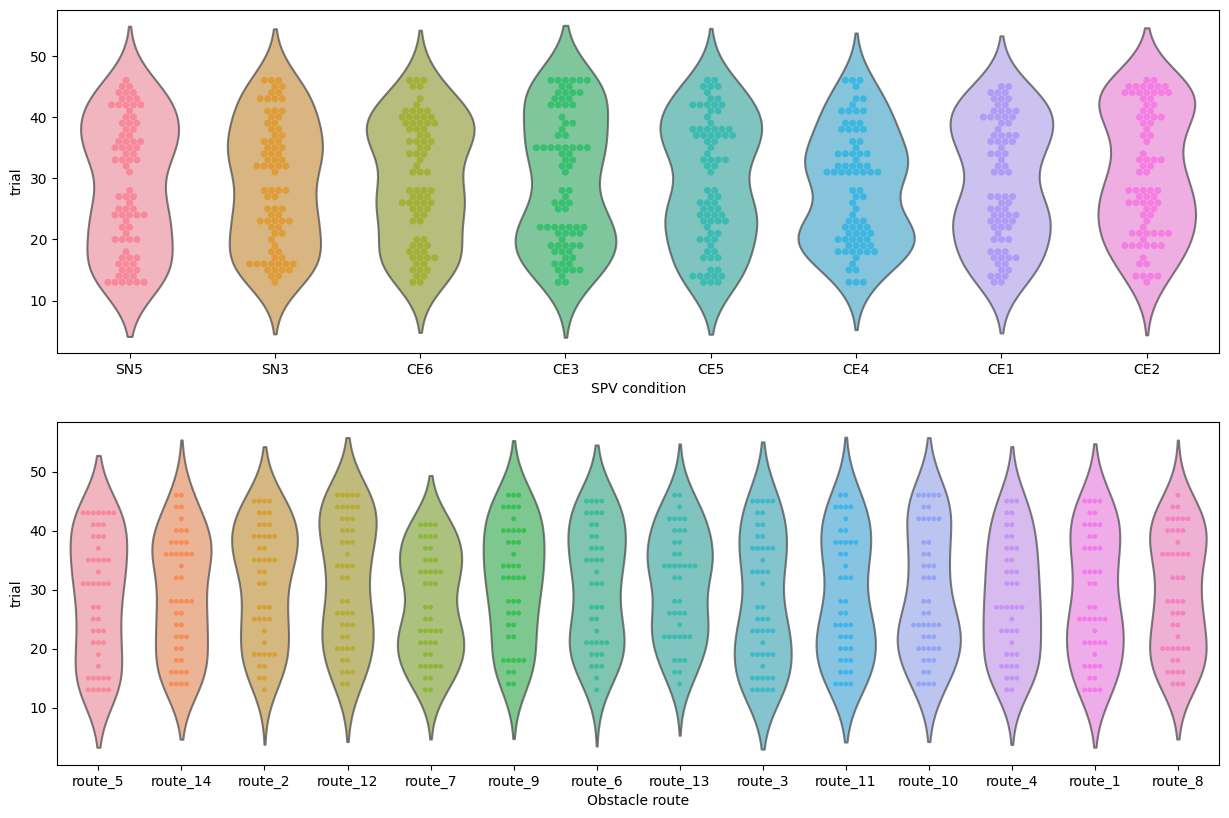

In [42]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15,10), dpi=100)
sns.violinplot(data=results.loc[results.condition_1!='CAM'], x='condition_1',y='trial', inner=None, ax = axes[0])
plt.setp(axes[0].collections, alpha=0.7)
sns.swarmplot(data=results.loc[results.condition_1!='CAM'], x='condition_1',y='trial', ax = axes[0])
axes[0].set_xlabel('SPV condition')
sns.violinplot(data=results.loc[results.condition_1!='CAM'], x='condition_3',y='trial', inner=None, ax = axes[1],)
plt.setp(axes[1].collections, alpha=0.7)
sns.swarmplot(data=results.loc[results.condition_1!='CAM'], x='condition_3',y='trial', size = 3.5, ax = axes[1])
axes[1].set_xlabel('Obstacle route')
plt.show()

#### 2.3 Performance for each subject

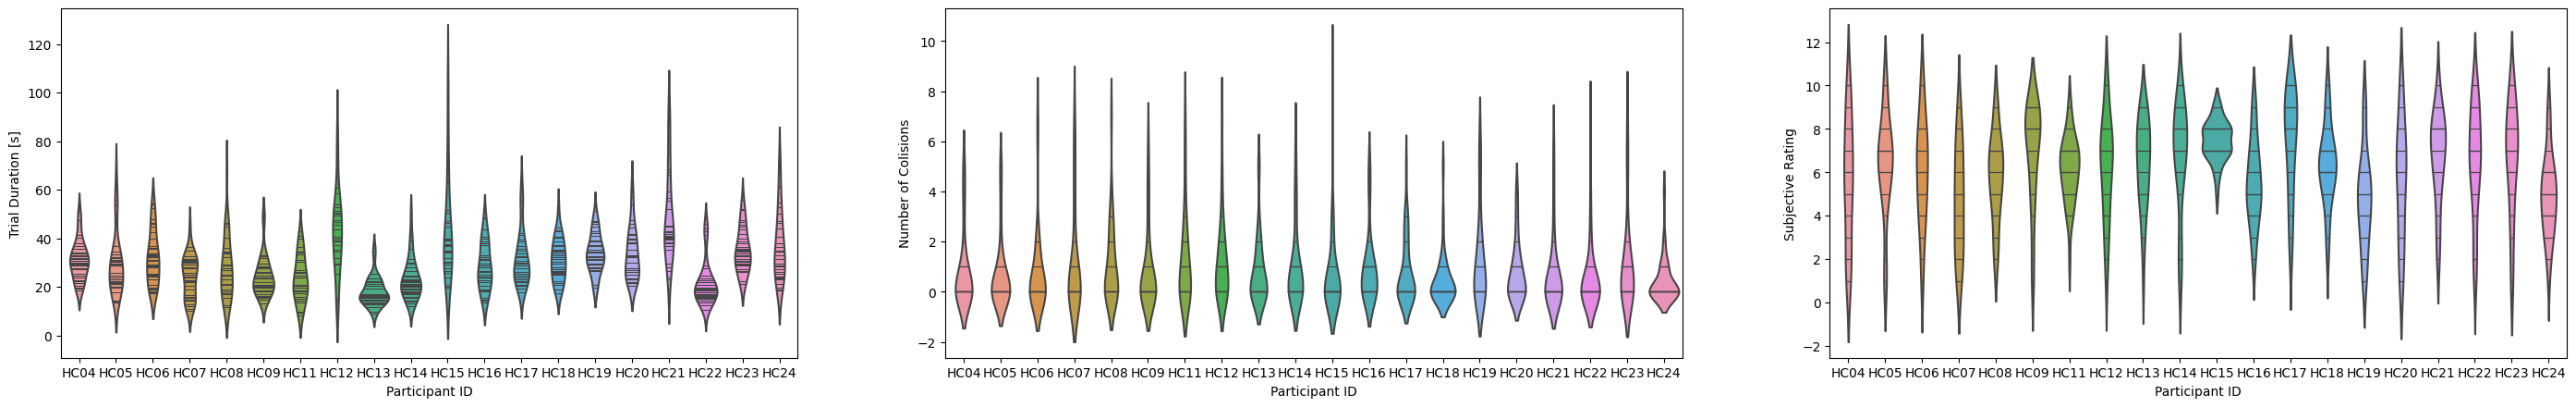

In [43]:
plt.figure(figsize=(35,5),dpi=100)
for i, (y,y_lbl) in enumerate ([('trial_duration', 'Trial Duration [s]'),
                      ('n_collisions', 'Number of Colisions'),
                      ('rating', 'Subjective Rating')],1):
    plt.subplot(1,3,i)
    sns.violinplot(data=results,x='participant',y=y, inner='stick')
    plt.ylabel(y_lbl)
    plt.xlabel('Participant ID')
plt.show()

## Uncomment below to inspect descriptive stats per participant
# avg = results.groupby('participant').describe()
# avg.loc[:,(endpoints,['mean', '50%','std'])]

^^^ Note the large variability between subjects ^^^

#### 2.4 Speed vs accuracy trade-off?

C:\Users\Jaap\Anaconda3\envs\py36\lib\site-packages\seaborn\distributions.py:1213: UserWarning: The following kwargs were not used by contour: 'size', 'sizes'
  **contour_kws,
C:\Users\Jaap\Anaconda3\envs\py36\lib\site-packages\seaborn\distributions.py:1213: UserWarning: The following kwargs were not used by contour: 'size', 'sizes'
  **contour_kws,


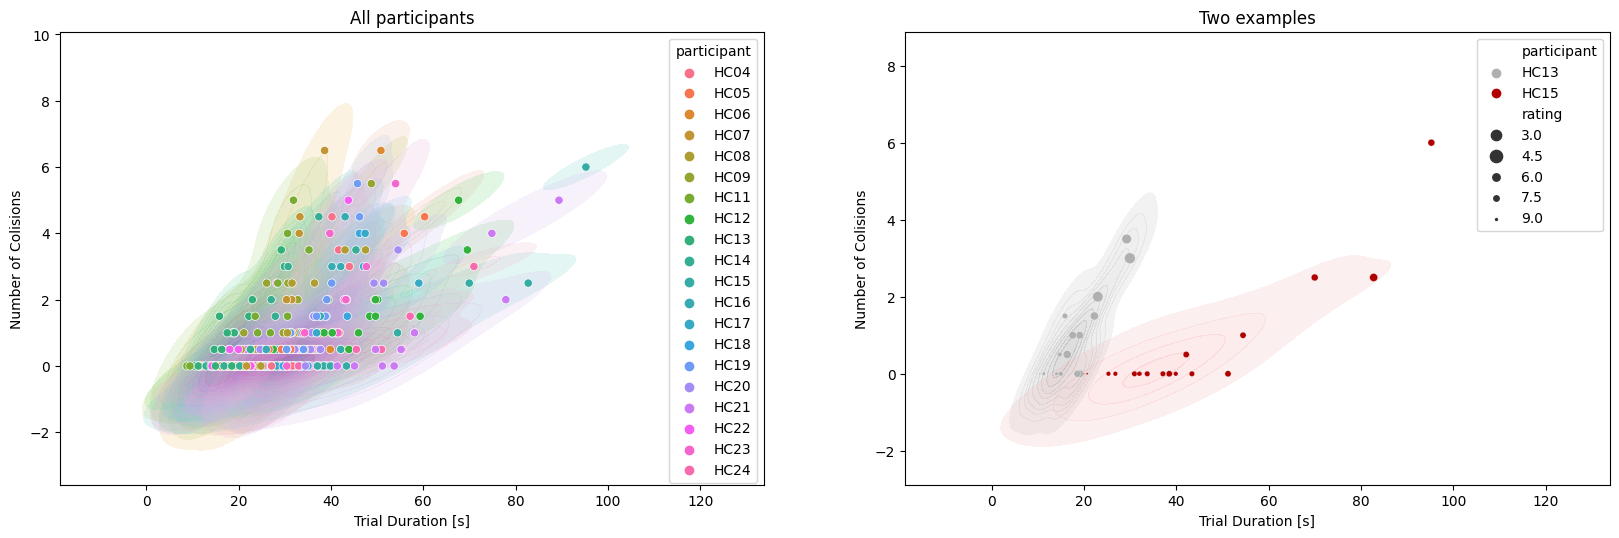

In [57]:
plt.figure(figsize=(20,6), dpi=100)

plt.subplot(1,2,1)
sns.kdeplot(data=avg_results,y='n_collisions',x='trial_duration',hue='participant',fill=True,alpha=0.2)
sns.scatterplot(data=avg_results,y='n_collisions',x='trial_duration',hue='participant')
plt.ylabel('Number of Colisions')
plt.xlabel('Trial Duration [s]')
plt.title('All participants')




plt.subplot(1,2,2)
ax = sns.kdeplot(data=avg_results.loc[avg_results.participant.isin(['HC13','HC15'])],
                     y='n_collisions',x='trial_duration',hue='participant',size='rating',sizes=(60,2),fill=True,alpha=0.2)
ax = sns.scatterplot(data=avg_results.loc[avg_results.participant.isin(['HC13','HC15'])],
                     y='n_collisions',x='trial_duration',hue='participant',size='rating',sizes=(60,2))
handles, labels = ax.get_legend_handles_labels()
within_range = [True if not l.isdigit() else (int(l)>0 and int(l)<11) for l in labels]
handles = [h for i,h in enumerate(handles) if within_range[i]]
labels  = [l for i,l in enumerate(labels) if within_range[i]]
plt.legend(handles,labels)
plt.ylabel('Number of Colisions')
plt.xlabel('Trial Duration [s]')
plt.title('Two examples')
plt.show()

^^^ Note that different subjects may have adopted a different strategy ('fast' vs 'accurate') ^^^

Ttest_relResult(statistic=1.6568224315965634, pvalue=0.13193535805789935)


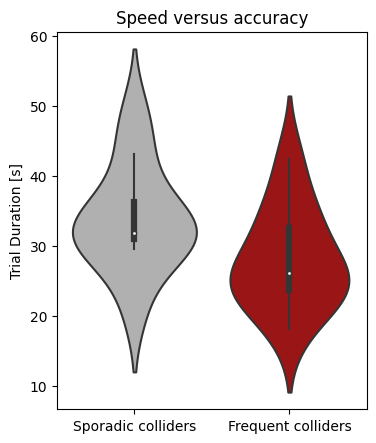

In [45]:
COLORS = ['#b0b0b0',"#b00000"]
sns.set_palette(COLORS)


# Grouped per participant and split into 'sporadic' vs 'frequent' colliders
ptcp_data = results.groupby(['participant']).mean()
mask = ptcp_data.n_collisions > ptcp_data.n_collisions.median()
ptcp_data.loc[~mask,'Category'] = 'Sporadic colliders'
ptcp_data.loc[mask,'Category'] = 'Frequent colliders'

# T-Test for differences in trial durations
print(ttest_rel(ptcp_data.loc[~mask,'trial_duration'],ptcp_data.loc[mask,'trial_duration']))

# Visualize
plt.figure(figsize=(4,5),dpi=100)
sns.violinplot(data=ptcp_data,y='trial_duration',x='Category')
plt.ylabel('Trial Duration [s]')
plt.xlabel('')
plt.title('Speed versus accuracy')


# # Significance
# h = 63
# plt.plot([0,0,1,1], [h-1.5,h,h,h-1.5], linewidth=1, color='k',)
# plt.text(0.45,h,'NS',verticalalignment='center',backgroundcolor='w',c='#424242')

plt.show()

(-0.13690623126151572, 0.564911768426767)

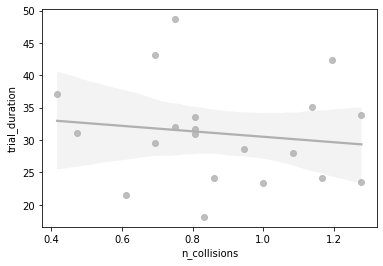

In [46]:
sns.regplot(data=ptcp_data, x='n_collisions', y='trial_duration')
scipy.stats.pearsonr(ptcp_data.n_collisions, ptcp_data.trial_duration)

#### 2.4 Learning effect or fatigue?

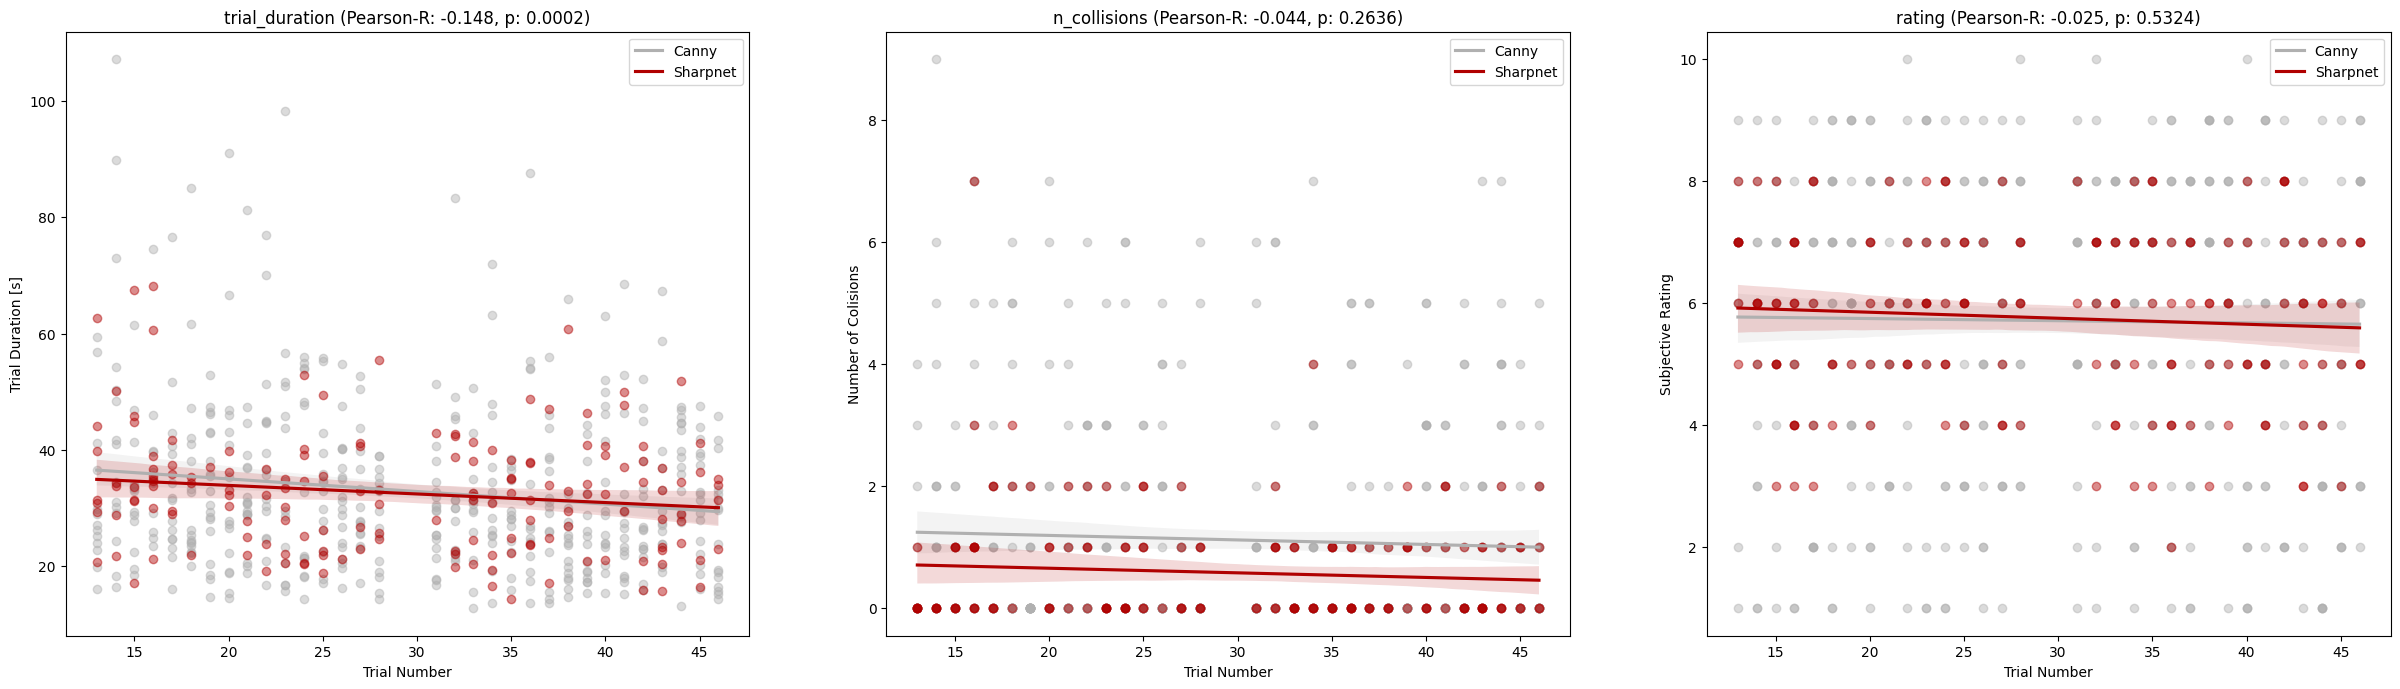

In [47]:
data = results.loc[results.model_type!='Camera']


plt.figure(figsize=(30,8),dpi=100)
for i, (y,y_lbl) in enumerate([('trial_duration', 'Trial Duration [s]'),
                      ('n_collisions', 'Number of Colisions'),
                      ('rating', 'Subjective Rating')],1): 
    plt.subplot(1,3,i)
    sns.regplot(data=results.loc[results.model_type=='Canny'], x='trial',y=y, scatter_kws={'alpha':0.45})
    sns.regplot(data=results.loc[results.model_type=='SharpNet'], x='trial',y=y, scatter_kws={'alpha':0.45})
    plt.legend(['Canny','Sharpnet'])
    plt.xlabel('Trial Number')
    plt.ylabel(y_lbl)
    
    stats = scipy.stats.pearsonr(data.trial,data[y])
    plt.title('{} (Pearson-R: {:.3f}, p: {:.4f})'.format(y,*stats))
plt.show()



^^^ Note that there is a small but significant correlation between trial number and performance (in particular: subjects walk *faster* in later trials) ^^^

In [48]:
avg_results.loc[avg_results.model_type != 'Camera'].groupby(['condition_1','condition_2']).mean()

trial  seed  session  trial_duration  framerate  \
condition_1 condition_2                                                    
CE1         complex      29.15  13.2      1.5        53.06800   29.91225   
            simple       29.75  13.2      1.5        46.90350   29.95700   
CE2         complex      31.60  13.2      1.5        44.43050   30.00000   
            simple       30.20  13.2      1.5        35.57600   30.00000   
CE3         complex      31.35  13.2      1.5        33.38375   30.00000   
            simple       28.10  13.2      1.5        31.10775   30.00000   
CE4         complex      28.80  13.2      1.5        27.48775   30.00000   
            simple       28.05  13.2      1.5        27.79800   30.00000   
CE5         complex      30.05  13.2      1.5        24.11575   30.00000   
            simple       29.10  13.2      1.5        25.07775   30.00000   
CE6         complex      30.40  13.2      1.5        21.36775   30.00000   
            simple       29.00  13.2      1.5        24.50350   30.00000   
SN3         complex      28.80  13.2      1.5        35.45225   18.23450   
            simple       29.60  13.2      1.5        34.83900   17.69750   
SN5         complex      29.85  13.2      1.5        30.35650   18.57450   
            simple       28.20  13.2      1.5        29.46650   18.83300   

                         rating  n_collisions  resolution  \
condition_1 condition_2                                     
CE1         complex       1.925         4.325       100.0   
            simple        2.525         2.875       100.0   
CE2         complex       3.875         2.575       324.0   
            simple        4.850         0.825       324.0   
CE3         complex       5.575         1.150       676.0   
            simple        5.875         0.400       676.0   
CE4         complex       7.050         0.575      1156.0   
            simple        6.725         0.250      1156.0   
CE5         complex       7.575         0.150      1764.0   
            simple        7.325         0.200      1764.0   
CE6         complex       7.850         0.050      2500.0   
            simple        7.425         0.100      2500.0   
SN3         complex       5.425         0.825       676.0   
            simple        5.200         0.700       676.0   
SN5         complex       6.125         0.425      1764.0   
            simple        6.300         0.400      1764.0   

                         standardized_rating  standardized_trial_duration  \
condition_1 condition_2                                                     
CE1         complex                -1.964746                     2.079178   
            simple                 -1.706655                     1.474404   
CE2         complex                -1.049697                     1.299002   
            simple                 -0.601206                     0.463328   
CE3         complex                -0.273276                     0.262387   
            simple                 -0.116026                     0.018577   
CE4         complex                 0.424053                    -0.296093   
            simple                  0.259855                    -0.292722   
CE5         complex                 0.663037                    -0.661212   
            simple                  0.557112                    -0.564765   
CE6         complex                 0.808068                    -0.930596   
            simple                  0.610926                    -0.634008   
SN3         complex                -0.338028                     0.431761   
            simple                 -0.432636                     0.360383   
SN5         complex                -0.007303                    -0.032918   
            simple                  0.070114                    -0.175212   

                         standardized_n_collisions  
condition_1 condition_2                             
CE1         complex                       2.557895  
           

## 3. Main Analysis

#### 3.0 Function definitions

In [27]:
from scipy.stats import shapiro
from scipy.stats import ttest_rel,wilcoxon

## Statistical tests
def paired_comparison(data, dep_vars, indep_vars, test=wilcoxon, paired_by=None):
    groups = data.groupby(indep_vars).groups
    groups = list(groups.items())
    result = {y:dict() for y in dep_vars}
    for y in dep_vars:
        for (cond1, mask1), (cond2, mask2) in zip(groups[1::2], groups[::2]):
            if paired_by is not None:
                T,p = test(data.loc[mask1].sort_values(paired_by)[y], data.loc[mask2].sort_values(paired_by)[y])
            else:
                T,p = test(data.loc[mask1,y],data.loc[mask2,y])           
            descr = '{} ({:} vs {:})'.format(cond1[0],cond1[1],cond2[1])
            result[y].update({(descr,'T'):T, (descr,'p'):p })
    return pd.DataFrame(result)


#### 3.1 Normality assessment

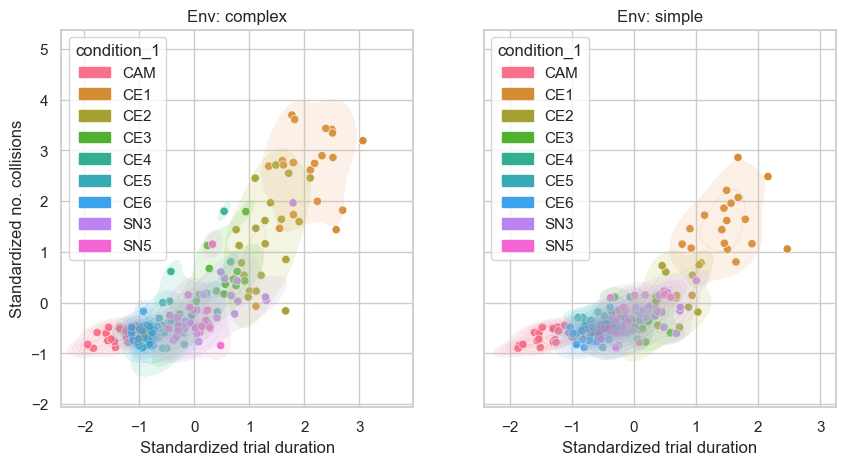

In [82]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(10,5),dpi=100, sharey=True)
sns.set(palette='plasma_r', font_scale=1.0, style='whitegrid')
for ax, (complexity, mask) in zip(axes, avg_results.groupby('condition_2').groups.items()):
    sns.scatterplot(data=avg_results.loc[mask],x='standardized_trial_duration', y='standardized_n_collisions',hue='condition_1',ax=ax)
    sns.kdeplot(data=avg_results.loc[mask],x='standardized_trial_duration', y='standardized_n_collisions',
                hue='condition_1', fill=True,alpha=0.2, ax=ax)
    ax.set(title='Env: {}'.format(complexity), xlabel='Standardized trial duration', ylabel='Standardized no. collisions')

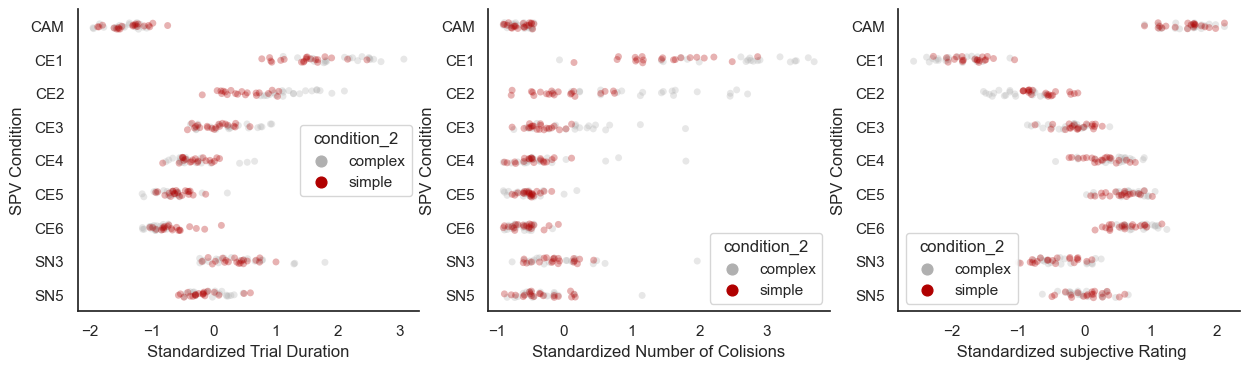

In [105]:
fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(15,4),dpi=100)
sns.set(palette=COLORS, font_scale=1.0, style='white')
endpoints = [('standardized_trial_duration', 'Standardized Trial Duration'),
            ('standardized_n_collisions', 'Standardized Number of Colisions'),
            ('standardized_rating', ' Standardized subjective Rating')]
for ax, (y,y_lbl) in zip(axes,endpoints):
    g = sns.stripplot(data=avg_results, x=y, y='condition_1', hue='condition_2',alpha=0.3, ax=ax,)
    ax.set(xlabel=y_lbl, ylabel='SPV Condition')
    sns.despine();

In [119]:
for y, y_lbl in endpoints:
    print('\n'+ y_lbl)
    for subgroup, mask in avg_results.groupby(['condition_1','condition_2']).groups.items():
        stat, p = shapiro(avg_results.loc[mask, y])
        conclusion = 'normal' if p>0.05 else 'non-normal'
        print('{}-{}:  p={:.4f} ({})'.format(*subgroup,p,conclusion))


Standardized Trial Duration
CAM-complex:  p=0.1321 (normal)
CAM-simple:  p=0.7830 (normal)
CE1-complex:  p=0.8406 (normal)
CE1-simple:  p=0.4636 (normal)
CE2-complex:  p=0.4957 (normal)
CE2-simple:  p=0.5742 (normal)
CE3-complex:  p=0.1897 (normal)
CE3-simple:  p=0.8065 (normal)
CE4-complex:  p=0.0029 (non-normal)
CE4-simple:  p=0.6633 (normal)
CE5-complex:  p=0.0683 (normal)
CE5-simple:  p=0.9244 (normal)
CE6-complex:  p=0.5784 (normal)
CE6-simple:  p=0.0832 (normal)
SN3-complex:  p=0.0867 (normal)
SN3-simple:  p=0.9777 (normal)
SN5-complex:  p=0.3917 (normal)
SN5-simple:  p=0.0137 (non-normal)

Standardized Number of Colisions
CAM-complex:  p=0.1632 (normal)
CAM-simple:  p=0.1632 (normal)
CE1-complex:  p=0.0266 (non-normal)
CE1-simple:  p=0.9550 (normal)
CE2-complex:  p=0.4378 (normal)
CE2-simple:  p=0.3089 (normal)
CE3-complex:  p=0.2803 (normal)
CE3-simple:  p=0.9162 (normal)
CE4-complex:  p=0.0001 (non-normal)
CE4-simple:  p=0.9346 (normal)
CE5-complex:  p=0.0612 (normal)
CE5-sim

#### 3.2 Canny edge detection trials
- six SPV resolutions
- complex environment vs simple environment (without background textures and within-surface gradients)

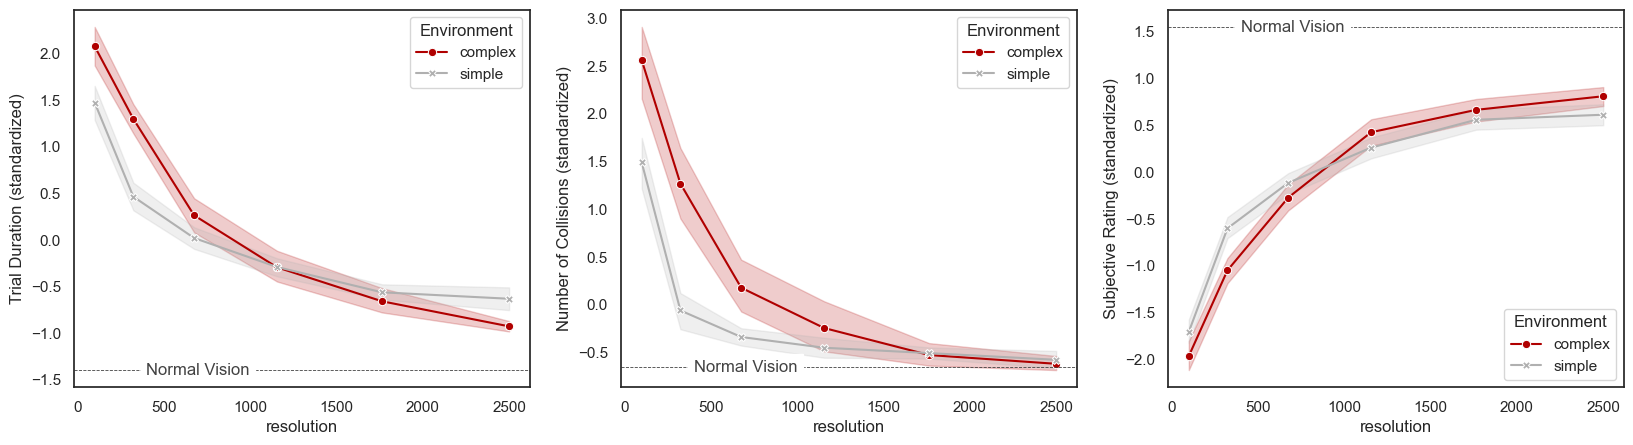

In [121]:
LOGSCALE = False
COLORS = ["#b00000", '#b0b0b0'] #["#c40000", '#9c9c9c']
PLOT_TYPE = 'curves' #'violins', 'curves', 'boxes'
STANDARDIZED = True

data = avg_results.loc[a.model_type=='Canny']
sns.set_palette(COLORS)


if STANDARDIZED:
    endpoints = [('standardized_trial_duration', 'Trial Duration (standardized)'),
                 ('standardized_n_collisions', 'Number of Collisions (standardized)'),
                 ('standardized_rating', 'Subjective Rating (standardized)')]
else:
    endpoints = [('trial_duration', 'Trial Duration [s]'),
                 ('n_collisions', 'Number of Colisions'),
                 ('rating', 'Subjective Rating'),]
    
plt.figure(figsize=(20,5),dpi=100)
for i,(y,y_lbl) in enumerate(endpoints):
    plt.subplot(1,3,i+1)
    
    if PLOT_TYPE == 'violins':
        g = sns.violinplot(x='condition_1', y=y, data=data,hue='condition_2', inner=None, split=True,scale='area', width=0.95)
        faces = [c for c in g.get_children() if isinstance(c, matplotlib.collections.PolyCollection)]
        for f in faces:
            f.set_alpha(0.3)
        g = sns.swarmplot(data=data,x='condition_1',y=y,hue='condition_2',marker='o',dodge=True,size=1.5)
        plt.xlabel('phosphene condition')
    elif PLOT_TYPE == 'curves':
        g=sns.lineplot(data=data,x='resolution',y=y,hue='condition_2', markers=True, style='condition_2',dashes=False,)
        if LOGSCALE:
            g.set(xscale="log")
    elif PLOT_TYPE == 'boxes':
        ax=sns.boxplot(data=data,x='condition_1',y=y,hue='condition_2', )
    
    maxp = avg_results[y].loc[(avg_results.condition_1=='CAM')].mean()
    minp = data[y].loc[(data.condition_1=='CE1')].mean()
    g.axhline(maxp,linestyle='--',linewidth=0.6,c='#424242') 
    
    plt.text(400,maxp,'Normal Vision',verticalalignment='center',backgroundcolor='w',c='#424242')
    plt.legend(['complex','simple'],title='Environment')
    plt.ylabel(y_lbl)

plt.show()


In [122]:
dep_vars   = ['standardized_trial_duration','standardized_n_collisions','standardized_rating']
indep_vars = ['condition_1','condition_2'] # Last element will be tested on, preceding elements are used for grouping
data = avg_results.loc[avg_results.model_type=='Canny', indep_vars + dep_vars]

paired_comparison(data, dep_vars, indep_vars, test=wilcoxon)

C:\Users\Jaap\Anaconda3\envs\py36\lib\site-packages\scipy\stats\morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
C:\Users\Jaap\Anaconda3\envs\py36\lib\site-packages\scipy\stats\morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


standardized_trial_duration  \
CE1 (simple vs complex) T                     8.000000   
                        p                     0.000293   
CE2 (simple vs complex) T                     1.000000   
                        p                     0.000103   
CE3 (simple vs complex) T                    51.000000   
                        p                     0.043804   
CE4 (simple vs complex) T                    97.000000   
                        p                     0.765198   
CE5 (simple vs complex) T                    66.000000   
                        p                     0.145400   
CE6 (simple vs complex) T                    11.000000   
                        p                     0.000449   

                           standardized_n_collisions  standardized_rating  
CE1 (simple vs complex) T                  25.000000            33.000000  
                        p                   0.002821             0.039474  
CE2 (simple vs complex) T                   4.000000            12.000000  
                        p                   0.000386             0.002263  
CE3 (simple vs complex) T                  12.000000            28.000000  
                        p                   0.003783             0.124043  
CE4 (simple vs complex) T                  29.000000            29.000000  
                        p                   0.432768             0.078292  
CE5 (simple vs complex) T                  17.000000            28.000000  
                        p                   0.888638             0.221330  
CE6 (simple vs complex) T                   6.000000            16.000000  
                        p                   0.345448             0.039243

#### 3.2 SharpNet versus Canny
- six SPV resolutions
- complex environment vs simple environment (without background textures and within-surface gradients)

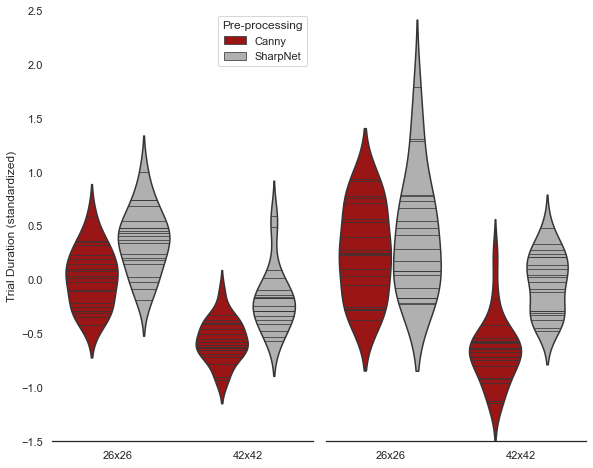

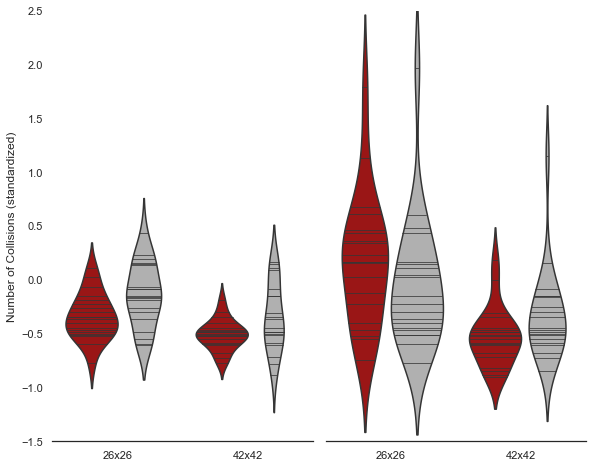

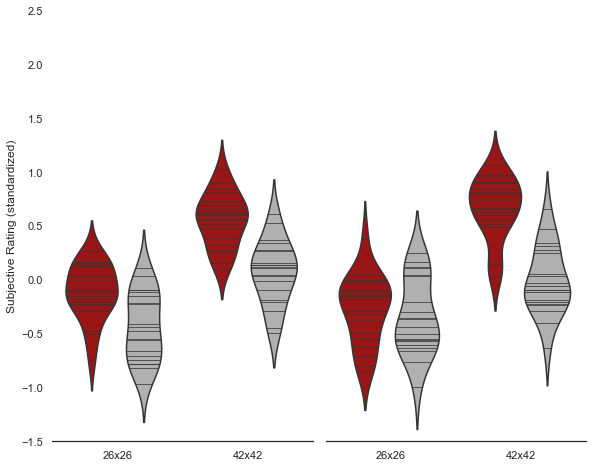

<Figure size 432x288 with 0 Axes>

In [124]:
for i,(y,y_lbl) in enumerate(endpoints):
    data = avg_results.loc[avg_results.resolution.isin([26*26,42*42])]
    ax = sns.catplot(x='resolution', y=y,
                     kind='violin',
                    hue="model_type", dpi=200,
                    height=7, aspect=.6, col='condition_2', xlabel='Phospene resolution', col_order=['simple','complex'],
                    data=data, legend=[True,False,False][i],legend_out=False, inner='stick')#order=['CE3','CE5', '','SN3','SN5']);

    plt.ylim(-1.5,2.5)
    ax.set_xticklabels(['26x26', '42x42'])
    ax.despine(left=True)
    ax.set_axis_labels('',y_lbl)
    if ax._legend:
        ax._legend.set_title('Pre-processing')
    ax.set_titles('')
    plt.show()
plt.tight_layout()


In [125]:
dep_vars   = ['standardized_trial_duration','standardized_n_collisions','standardized_rating']
indep_vars = ['resolution','model_type'] # Last element will be tested on, preceding elements are used for grouping

paired_comparison(data, dep_vars, indep_vars, test=wilcoxon)

standardized_trial_duration  \
676.0 (SharpNet vs Canny)  T                 2.290000e+02   
                           p                 1.497948e-02   
1764.0 (SharpNet vs Canny) T                 4.400000e+01   
                           p                 8.675900e-07   

                              standardized_n_collisions  standardized_rating  
676.0 (SharpNet vs Canny)  T                 174.500000         1.400000e+02  
                           p                   0.727540         1.205158e-02  
1764.0 (SharpNet vs Canny) T                  60.000000         1.000000e+00  
                           p                   0.030798         1.827573e-07

## 4. Exit Survey

In [127]:
fn    =  '../Data/anonymized_exit_surveys.csv'
data  = pd.read_csv(fn, delimiter=',')
remap = {c:'Q{}'.format(i+1) for i,c in enumerate(data.columns[-5:])}
data.rename(columns=remap,inplace=True)
legend= {v:k for k,v in remap.items()}

data.Q4 = data.Q4.apply(lambda x: [i for i in x.split(', ')])
reindex =  {
    'Erg kort'                : '1 - Very Short',
    'Kort'                    : '2 - Short',
    'Volgens verwachting/goed': '3 - As Expected',
    'Lang'                    : '4 - Long',
    'Te lang'                 : '5 - Very Long',
    'Ja, ik had voldoende geoefend':
                                '2 - Sufficient',
    'Nee, ik had graag meer tijd genomen om te wennen aan het beeld':
                                '1 - Insufficient',
    'Ja, ik merkte een groot verschil in hoe goed ik kon navigeren':
                                '3 - Large improvement',
    'Ik merkte een klein verschil in hoe goed ik kon navigeren':
                            '2 - Minor improvement',}

data = data.replace(reindex)


for q in ['Q1','Q2','Q3']:
    response = data[q].value_counts().sort_index()*100/len(data) 
    print(pd.Series(response).rename('{} - {}'.format(q, legend[q])))
    print('\n')
    
response = dict()
options = {option_checked for answer in data.Q4 for option_checked in answer}
for option in options:
    response[option] = sum([option in answer for answer in data.Q4])/len(data)
response = pd.Series(response).sort_values(ascending=False)
print(response.rename('Q4 - {}'.format(legend['Q4'])))

print('Q5 - Overige opmerkingen:')
for i,response in enumerate(data.Q5):
    print("{}. {}\n".format(i+1,response))

    
#  Important note: Some participants did not check the box for lines or textures in Question 4, 
#  but DID explicitly mention it in question 5. Wich is why we should correct this percentage:

q5_textures_mentioned = [False,True,False,False,False,True,False,True,False,False,False,False,True,False,False,False,True]
q4_textures_mentioned = ['Verschil in lijnen/textuur tussen de vloer' in response for response in data.Q4]
sum([x or y for x,y in zip(q4_textures_mentioned,q5_textures_mentioned)])/len(data)

2 - Short          11.764706
3 - As Expected    64.705882
4 - Long           23.529412
Name: Q1 - Hoe heb je de tijdsduur ervaren?, dtype: float64


1 - Insufficient    17.647059
2 - Sufficient      82.352941
Name: Q2 - Het experiment begon met zes oefen-rondes. Had je het gevoel dat je hierna voldoende gewend was aan het fosfeen-beeld?, dtype: float64


2 - Minor improvement    29.411765
3 - Large improvement    70.588235
Name: Q3 - Heb je het gevoel dat je, ongeacht de hoeveelheid fosfenen, beter ging navigeren naarmate je vaker had gelopen?, dtype: float64


Herkennen van lijnen                                  0.941176
Vermijden van groepen lichtpuntjes                    0.647059
Opzoeken van lege ruimten                             0.588235
Mijn strategie veranderde gedurende het experiment    0.529412
Intuïtief/op geluk gelopen                            0.470588
Verschil in lijnen/textuur tussen de vloer            0.411765
dozen en muur                                         

0.5294117647058824